# Predicting survival times in glioblastoma patients using gene expression and treatment data

In [1]:
# imports
import xenaPython as xena
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
import dataframe_image as dfi

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\chris\anaconda3\lib\site-packages\xenaPython\__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


In [2]:
# help(xena)

# Data Loading & Transformation

## List of Samples

In [3]:
# samples
dataset = 'TCGA.GBM.sampleMap/GBM_clinicalMatrix'
host = 'https://tcga.xenahubs.net'
samples = xena.dataset_samples(host, dataset, None)
len(samples)

629

In [4]:
# samples

### Survival

In [5]:
# survival
surv = pd.read_csv('survival_GBM_survival.txt', header = None, delimiter="\t")
surv

,0,1,2,3,4,5,6,7,8,9,10
0,sample,_PATIENT,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
1,TCGA-02-0001-01,TCGA-02-0001,1,358,1,358,NaN,NaN,1,137,NaN
2,TCGA-02-0003-01,TCGA-02-0003,1,144,1,144,NaN,NaN,1,40,NaN
3,TCGA-02-0006-01,TCGA-02-0006,1,558,1,558,NaN,NaN,1,302,NaN
4,TCGA-02-0007-01,TCGA-02-0007,1,705,1,705,NaN,NaN,1,518,NaN
...,...,...,...,...,...,...,...,...,...,...,...
598,TCGA-87-5896-01,TCGA-87-5896,0,800,0,800,0,800,0,800,NaN
599,TCGA-OX-A56R-01,TCGA-OX-A56R,1,180,1,180,NaN,NaN,1,180,NaN
600,TCGA-RR-A6KA-01,TCGA-RR-A6KA,1,191,1,191,NaN,NaN,1,191,NaN
601,TCGA-RR-A6KB-01,TCGA-RR-A6KB,0,0,0,0,NaN,NaN,0,0,NaN


In [6]:
# # make the first row the header
surv.columns = surv.iloc[0]

# # Get rid of the duplicate first row
surv = surv.iloc[1:,:]

# check for nans
surv['OS.time'].isnull().values.any()

False

#### Survival

In [7]:
# keep the sample index in case multiple samples belong to one patient
# we should use OS time since it is available, instead of the binary OSS
# including OS in the df will be helpful for plotting 
os = surv[['sample','OS.time', 'OS']]
os['OS.time'] = os['OS.time'].astype(float)
os['OS.months'] = (os['OS.time']/30)

# Low/High survival binary
os['LHS'] = np.where(os['OS.months']>=15, 1, 0)
os

,sample,OS.time,OS,OS.months,LHS
1,TCGA-02-0001-01,358.0,1,11.933333,0
2,TCGA-02-0003-01,144.0,1,4.800000,0
3,TCGA-02-0006-01,558.0,1,18.600000,1
4,TCGA-02-0007-01,705.0,1,23.500000,1
5,TCGA-02-0009-01,322.0,1,10.733333,0
...,...,...,...,...,...
598,TCGA-87-5896-01,800.0,0,26.666667,1
599,TCGA-OX-A56R-01,180.0,1,6.000000,0
600,TCGA-RR-A6KA-01,191.0,1,6.366667,0
601,TCGA-RR-A6KB-01,0.0,0,0.000000,0


In [8]:
# Statistics
original_med_months = os['OS.months'].median()
print('Median survival (months):', original_med_months)

# How many are low/high?
original_low_high = os['LHS'].value_counts()
original_low_high

# summary for OS.time
original_os_sum = os['OS.time'].describe()
original_os_sum

# The groups are still pretty well balanced

Median survival (months): 12.333333333333334


count     602.000000
mean      500.642857
std       536.364905
min         0.000000
25%       167.500000
50%       370.000000
75%       609.250000
max      3881.000000
Name: OS.time, dtype: float64

### Plot of survival in the entire database

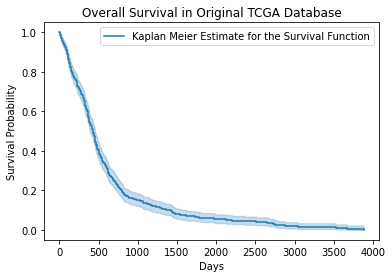

In [9]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 

os['OS'] = os['OS'].astype(float)
os['OS.time'] = os['OS.time'].astype(float)

durations = os['OS.time'].tolist()
event_observed = os['OS'].tolist()

kmf.fit(durations, event_observed, label='Kaplan Meier Estimate for the Survival Function')
kmf.plot()
plt.title('Overall Survival in Original TCGA Database')
plt.ylabel('Survival Probability')
plt.xlabel('Days')
plt.savefig('survival_original.pdf', transparent=True)
plt.savefig('survival_original.png')

## Clinical Data

In [10]:
tsv_file = open("TCGA.GBM.sampleMap_GBM_clinicalMatrix")
read_tsv = csv.reader(tsv_file, delimiter="\t")
clin = pd.DataFrame(read_tsv)
clin

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,sampleID,CDE_DxAge,CDE_alk_chemoradiation_standard,CDE_chemo_adjuvant_alk,CDE_chemo_adjuvant_tmz,CDE_chemo_alk,CDE_chemo_alk_days,CDE_chemo_alk_long,CDE_chemo_tmz,CDE_chemo_tmz_days,...,_GENOMIC_ID_TCGA_GBM_exp_u133a,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_GBM_RPPA_RBN,_GENOMIC_ID_TCGA_GBM_gistic2thd,_GENOMIC_ID_TCGA_GBM_PDMRNAseqCNV,_GENOMIC_ID_TCGA_GBM_mutation,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_GBM_gistic2,_GENOMIC_ID_TCGA_GBM_hMethyl450
1,TCGA-02-0001-01,44.3,FALSE,FALSE,FALSE,FALSE,0,FALSE,FALSE,0,...,03c14838-bbab-4487-80c3-c5fdf6ec83f9,,,TCGA-02-0001-01C-01D-0182-01,,,,,TCGA-02-0001-01C-01D-0182-01,
2,TCGA-02-0002-01,,,,,,,,,,...,,,,,,,,,,
3,TCGA-02-0003-01,50.21,FALSE,FALSE,FALSE,FALSE,0,FALSE,FALSE,0,...,4298ad72-e8eb-4749-95da-cce602107724,,TCGA-02-0003-01A-21-1898-20,TCGA-02-0003-01A-01D-0182-01,,TCGA-02-0003-01A-01D-1490-08,,,TCGA-02-0003-01A-01D-0182-01,
4,TCGA-02-0004-01,59.18,TRUE,TRUE,TRUE,TRUE,110,TRUE,TRUE,110,...,1bc1d8d2-8c34-4b03-9275-38c68323816e,,TCGA-02-0004-01A-21-1898-20,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,TCGA-87-5896-01,50.35,FALSE,FALSE,FALSE,FALSE,0,FALSE,FALSE,0,...,5d4b2115-054e-4026-b2e0-9c8ec0137b57,,,TCGA-87-5896-01A-01D-1694-01,,TCGA-87-5896-01A-01D-1696-08,,,TCGA-87-5896-01A-01D-1694-01,TCGA-87-5896-01A-01D-1697-05
626,TCGA-OX-A56R-01,,,,,,,,,,...,,,,TCGA-OX-A56R-01A-11D-A33S-01,,,,,TCGA-OX-A56R-01A-11D-A33S-01,TCGA-OX-A56R-01A-11D-A33U-05
627,TCGA-RR-A6KA-01,,,,,,,,,,...,,,,TCGA-RR-A6KA-01A-21D-A33S-01,,,,,TCGA-RR-A6KA-01A-21D-A33S-01,TCGA-RR-A6KA-01A-21D-A33U-05
628,TCGA-RR-A6KB-01,,,,,,,,,,...,,,,TCGA-RR-A6KB-01A-12D-A33S-01,,,,,TCGA-RR-A6KB-01A-12D-A33S-01,TCGA-RR-A6KB-01A-12D-A33U-05


In [11]:
# only include radiation 
print(clin.iloc[0].values)

# radiation: 'CDE_radiation_standard', 'CDE_radiation_adjuvant_standard', 'CDE_radiation_adjuvant'
# chemo: 'CDE_chemo_adjuvant_alk', 'CDE_chemo_adjuvant_tmz', 'CDE_chemo_alk', 'CDE_chemo_tmz'
# combo: 'CDE_alk_chemoradiation_standard', 'CDE_tmz_chemoradiation_standard'


['sampleID' 'CDE_DxAge' 'CDE_alk_chemoradiation_standard'
 'CDE_chemo_adjuvant_alk' 'CDE_chemo_adjuvant_tmz' 'CDE_chemo_alk'
 'CDE_chemo_alk_days' 'CDE_chemo_alk_long' 'CDE_chemo_tmz'
 'CDE_chemo_tmz_days' 'CDE_chemo_tmz_long' 'CDE_missing' 'CDE_missingflag'
 'CDE_previously_treated' 'CDE_radiation_adjuvant'
 'CDE_radiation_adjuvant_standard'
 'CDE_radiation_adjuvant_standard_probable' 'CDE_radiation_any'
 'CDE_radiation_standard' 'CDE_radiation_standard_probable'
 'CDE_sourcesite' 'CDE_survival_time' 'CDE_suspect' 'CDE_therapy'
 'CDE_tmz_chemoradiation_standard' 'CDE_vital_status' 'G_CIMP_STATUS'
 'GeneExp_Subtype' 'In_Cancer_Cell_Paper' '_INTEGRATION'
 '_PANCAN_CNA_PANCAN_K8' '_PANCAN_Cluster_Cluster_PANCAN'
 '_PANCAN_DNAMethyl_GBM' '_PANCAN_DNAMethyl_PANCAN'
 '_PANCAN_RPPA_PANCAN_K8' '_PANCAN_UNC_RNAseq_PANCAN_K16'
 '_PANCAN_mutation_PANCAN' '_PATIENT' '_cohort' '_primary_disease'
 '_primary_site' 'additional_chemo_therapy' 'additional_drug_therapy'
 'additional_immuno_therapy' 'add

In [12]:
# make the first row the header
clin.columns = clin.iloc[0]

# Get rid of the duplicate first row
clin = clin.iloc[1:,:]
clin

,sampleID,CDE_DxAge,CDE_alk_chemoradiation_standard,CDE_chemo_adjuvant_alk,CDE_chemo_adjuvant_tmz,CDE_chemo_alk,CDE_chemo_alk_days,CDE_chemo_alk_long,CDE_chemo_tmz,CDE_chemo_tmz_days,...,_GENOMIC_ID_TCGA_GBM_exp_u133a,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_GBM_RPPA_RBN,_GENOMIC_ID_TCGA_GBM_gistic2thd,_GENOMIC_ID_TCGA_GBM_PDMRNAseqCNV,_GENOMIC_ID_TCGA_GBM_mutation,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_GBM_gistic2,_GENOMIC_ID_TCGA_GBM_hMethyl450
1,TCGA-02-0001-01,44.3,FALSE,FALSE,FALSE,FALSE,0,FALSE,FALSE,0,...,03c14838-bbab-4487-80c3-c5fdf6ec83f9,,,TCGA-02-0001-01C-01D-0182-01,,,,,TCGA-02-0001-01C-01D-0182-01,
2,TCGA-02-0002-01,,,,,,,,,,...,,,,,,,,,,
3,TCGA-02-0003-01,50.21,FALSE,FALSE,FALSE,FALSE,0,FALSE,FALSE,0,...,4298ad72-e8eb-4749-95da-cce602107724,,TCGA-02-0003-01A-21-1898-20,TCGA-02-0003-01A-01D-0182-01,,TCGA-02-0003-01A-01D-1490-08,,,TCGA-02-0003-01A-01D-0182-01,
4,TCGA-02-0004-01,59.18,TRUE,TRUE,TRUE,TRUE,110,TRUE,TRUE,110,...,1bc1d8d2-8c34-4b03-9275-38c68323816e,,TCGA-02-0004-01A-21-1898-20,,,,,,,
5,TCGA-02-0006-01,56.17,FALSE,TRUE,TRUE,TRUE,61,TRUE,TRUE,61,...,,,,TCGA-02-0006-01B-01D-0182-01,,,,,TCGA-02-0006-01B-01D-0182-01,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,TCGA-87-5896-01,50.35,FALSE,FALSE,FALSE,FALSE,0,FALSE,FALSE,0,...,5d4b2115-054e-4026-b2e0-9c8ec0137b57,,,TCGA-87-5896-01A-01D-1694-01,,TCGA-87-5896-01A-01D-1696-08,,,TCGA-87-5896-01A-01D-1694-01,TCGA-87-5896-01A-01D-1697-05
626,TCGA-OX-A56R-01,,,,,,,,,,...,,,,TCGA-OX-A56R-01A-11D-A33S-01,,,,,TCGA-OX-A56R-01A-11D-A33S-01,TCGA-OX-A56R-01A-11D-A33U-05
627,TCGA-RR-A6KA-01,,,,,,,,,,...,,,,TCGA-RR-A6KA-01A-21D-A33S-01,,,,,TCGA-RR-A6KA-01A-21D-A33S-01,TCGA-RR-A6KA-01A-21D-A33U-05
628,TCGA-RR-A6KB-01,,,,,,,,,,...,,,,TCGA-RR-A6KB-01A-12D-A33S-01,,,,,TCGA-RR-A6KB-01A-12D-A33S-01,TCGA-RR-A6KB-01A-12D-A33U-05


In [13]:
##### Radiation #####
rt = clin[['sampleID', 
              'CDE_radiation_adjuvant',
              'CDE_radiation_adjuvant_standard',
              'CDE_radiation_standard']].copy()

# convert to bool
rt['CDE_radiation_adjuvant'] = rt['CDE_radiation_adjuvant'].replace({'TRUE':True, 'FALSE':False})
rt['CDE_radiation_adjuvant_standard'] = rt['CDE_radiation_adjuvant_standard'].replace({'TRUE':True, 'FALSE':False})
rt['CDE_radiation_standard'] = rt[ 'CDE_radiation_standard'].replace({'TRUE':True, 'FALSE':False})

# figure out which samples have received any sort of radiation
rt['received_rt'] = rt[['CDE_radiation_adjuvant',
                          'CDE_radiation_adjuvant_standard',
                          'CDE_radiation_standard']].any(axis='columns') # took out 'sampleID, , bool_only=True

rts = rt[['sampleID', 'received_rt']]

##### ChemoRadiation #####
chemrt = clin[['sampleID', 
              'CDE_alk_chemoradiation_standard', 
              'CDE_tmz_chemoradiation_standard']].copy()

# convert to bool
chemrt['CDE_alk_chemoradiation_standard'] = chemrt['CDE_alk_chemoradiation_standard'].replace({'TRUE':True, 'FALSE':False})
chemrt['CDE_tmz_chemoradiation_standard'] = chemrt['CDE_tmz_chemoradiation_standard'].replace({'TRUE':True, 'FALSE':False})

# figure out which samples have received any sort of chemotherapy
chemrt['received_chemrt'] = chemrt[['CDE_alk_chemoradiation_standard',  
                                  'CDE_tmz_chemoradiation_standard']].any(axis='columns')

chemrts = chemrt[['sampleID', 'received_chemrt']]

##### Chemo #####
chem = clin[['sampleID', 
              'CDE_chemo_adjuvant_alk', 
              'CDE_chemo_adjuvant_tmz']].copy()

# convert to bool
chem['CDE_chemo_adjuvant_alk'] = chem['CDE_chemo_adjuvant_alk'].replace({'TRUE':True, 'FALSE':False})
chem['CDE_chemo_adjuvant_tmz'] = chem['CDE_chemo_adjuvant_tmz'].replace({'TRUE':True, 'FALSE':False})

# figure out which samples have received any sort of chemotherapy
chem['received_chem'] = chem[['CDE_chemo_adjuvant_alk', 
                                      'CDE_chemo_adjuvant_tmz']].any(axis='columns')

chems = chem[['sampleID', 'received_chem']]

##### No treatment #####

# merge
treats1 = rts.merge(chemrts, how='inner', left_on='sampleID', right_on='sampleID')
treatments = treats1.merge(chems, how='inner', left_on='sampleID', right_on='sampleID')

# convert to bool
treatments['received_rt'] = treatments['received_rt'].replace({'True':True, 'False':False})
treatments['received_chem'] = treatments['received_chem'].replace({'True':True, 'False':False})
treatments['received_chemrt'] = treatments['received_chemrt'].replace({'True':True, 'False':False})

# figure out which samples have not been treated
treatments['treated'] = treatments[['received_rt', 
                            'received_chem',
                            'received_chemrt']].any(axis='columns')

treated = treatments[['sampleID', 'treated']]

In [119]:
rec = clin[['sampleID', 
              'days_to_tumor_recurrence']].copy()

rec

,sampleID,days_to_tumor_recurrence
1,TCGA-02-0001-01,137
2,TCGA-02-0002-01,
3,TCGA-02-0003-01,40
4,TCGA-02-0004-01,
5,TCGA-02-0006-01,302
...,...,...
625,TCGA-87-5896-01,
626,TCGA-OX-A56R-01,
627,TCGA-RR-A6KA-01,
628,TCGA-RR-A6KB-01,


## Genetic Profiling

In [14]:
# gene/probe names
dataset = 'TCGA.GBM.sampleMap/HT_HG-U133A'
host = 'https://tcga.xenahubs.net'
probes = xena.dataset_field(host, dataset)

In [15]:
# gene/probe values 
dataset = 'TCGA.GBM.sampleMap/HT_HG-U133A'
host = 'https://tcga.xenahubs.net'
values = xena.dataset_fetch(host, dataset, samples, probes)

In [16]:
len(probes)

12043

In [17]:
genes = pd.DataFrame(values)

# replace the blank column names with the sample names from above
genes.columns = samples

# transpose
genes = genes.transpose()

# replace the column names, again, with the gene names
genes.columns = probes

# The final three columns are not genes
genes = genes.drop(columns=['hCG_40738', 'sampleID', 'tcag7.1314'])

# fix type
genes = genes.astype(float)
genes

# The nans will be fixed below after the df is joined with treatments and os

,A2BP1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAK1,AAMP,AANAT,...,ZSCAN5,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3
TCGA-02-0001-01,5.409,10.28,5.639,5.108,5.508,6.501,4.752,4.901,7.236,3.474,...,4.968,5.606,5.417,7.745,4.218,4.643,5.537,7.115,5.700,6.360
TCGA-02-0002-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-02-0003-01,4.972,11.47,5.276,4.349,5.478,6.539,5.885,4.564,7.311,3.321,...,4.821,6.438,6.536,8.212,3.777,4.008,6.327,6.888,5.446,7.456
TCGA-02-0004-01,4.963,12.38,5.440,4.052,5.812,7.378,3.988,4.542,7.824,3.463,...,4.608,6.651,6.465,7.795,3.967,3.819,5.700,8.996,5.473,8.092
TCGA-02-0006-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-87-5896-01,6.623,11.70,5.113,4.052,6.954,7.230,4.173,4.996,8.609,3.263,...,5.488,7.256,7.417,8.740,4.256,4.327,6.053,10.780,5.934,8.328
TCGA-OX-A56R-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-RR-A6KA-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-RR-A6KB-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create X and y

### V1 with all of the treatments as features

In [18]:
# Add rt to features so samples line up
rt_binary = rts[['received_rt']]
rt_binary['received_rt'] = rts['received_rt'].astype(float).astype(object)
rt_binary.index = rts['sampleID']

# Add chemo to features so samples line up
chem_binary = chems[['received_chem']]
chem_binary['received_chem'] = chems['received_chem'].astype(float).astype(object)
chem_binary.index = chems['sampleID']

# add chemrt to features so samples line up
chemrt_binary = chemrts[['received_chemrt']]
chemrt_binary['received_chemrt'] = chemrts['received_chemrt'].astype(float).astype(object)
chemrt_binary.index = chemrts['sampleID']

# add no_treat to features for plotting
treat_binary = treated[['treated']]
treat_binary['treated'] = treated['treated'].astype(float).astype(object)
treat_binary.index = treated['sampleID']

merge1 = genes.merge(rt_binary, how='inner', left_index=True, right_index=True)
merge2 = merge1.merge(chem_binary, how='inner', left_index=True, right_index=True)
merge3 = merge2.merge(chemrt_binary, how='inner', left_index=True, right_index=True)
features_all = merge3.merge(treat_binary, how='inner', left_index=True, right_index=True)

# fix the os dataframe for joining
os2 = os[['OS.time', 'OS', 'LHS', 'OS.months']].copy()
os2.index = os['sample']

# # make a dataframe with os, rt, and genes
# # filter out nans in os and genes
full_df = features_all.merge(os2, how='inner', left_index=True, right_index=True)
full_df = full_df.dropna()
full_df

,A2BP1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAK1,AAMP,AANAT,...,ZZEF1,ZZZ3,received_rt,received_chem,received_chemrt,treated,OS.time,OS,LHS,OS.months
TCGA-02-0001-01,5.409,10.280,5.639,5.108,5.508,6.501,4.752,4.901,7.236,3.474,...,5.700,6.360,1.0,0.0,0.0,1.0,358.0,1.0,0,11.933333
TCGA-02-0003-01,4.972,11.470,5.276,4.349,5.478,6.539,5.885,4.564,7.311,3.321,...,5.446,7.456,1.0,0.0,0.0,1.0,144.0,1.0,0,4.800000
TCGA-02-0007-01,5.335,4.291,5.281,4.824,6.352,7.187,4.653,4.673,7.424,3.719,...,5.351,6.918,1.0,1.0,1.0,1.0,705.0,1.0,1,23.500000
TCGA-02-0009-01,5.055,10.350,5.124,4.205,5.496,7.675,4.759,4.405,8.052,3.426,...,5.152,7.114,1.0,0.0,0.0,1.0,322.0,1.0,0,10.733333
TCGA-02-0010-01,5.331,8.550,5.351,4.730,5.762,7.996,7.704,4.709,8.435,3.472,...,5.045,6.421,1.0,1.0,0.0,1.0,1077.0,1.0,1,35.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-6193-01,6.451,13.400,5.233,4.058,5.836,6.908,4.171,4.646,8.206,3.362,...,5.987,8.211,0.0,0.0,0.0,0.0,82.0,1.0,0,2.733333
TCGA-76-6282-01,5.337,12.560,5.367,4.252,6.287,7.008,4.259,4.742,8.261,3.343,...,6.040,8.142,0.0,0.0,0.0,0.0,519.0,1.0,1,17.300000
TCGA-76-6285-01,5.020,12.160,5.131,4.149,6.741,7.676,4.040,4.534,8.568,3.316,...,5.736,8.595,0.0,0.0,0.0,0.0,254.0,1.0,0,8.466667
TCGA-81-5910-01,4.871,10.840,5.007,4.366,6.643,7.105,4.135,4.563,8.328,3.439,...,6.135,8.243,0.0,0.0,0.0,0.0,49.0,1.0,0,1.633333


#### Survival statistics in the entire database (minus patients missing data)

In [19]:
# Statistics
full_med_months = full_df['OS.months'].median()
print('Median survival (months):', full_med_months)

# How many are low/high?
full_low_high = full_df['LHS'].value_counts()
full_low_high

# summary for OS.time
full_os_sum = full_df['OS.time'].describe()
full_os_sum

# The groups are still pretty well balanced

Median survival (months): 12.583333333333332


count     518.000000
mean      512.088803
std       541.852136
min         3.000000
25%       181.000000
50%       377.500000
75%       619.500000
max      3881.000000
Name: OS.time, dtype: float64

#### Plot of survival in the entire database (minus patients missing data)

We don't plot Low/High survival because it doesn't truly represent survival in the tradiational way. It would be confusing to say that after 300 days, Patient X was classified as low survival, or after 1500 days, Patient Y was classified as high survival. This isn't a true "event."

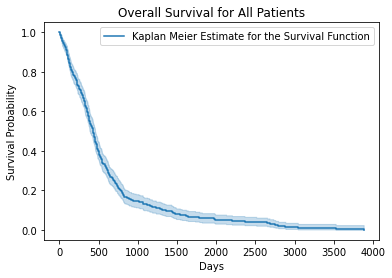

In [20]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 

full_df['OS'] = full_df['OS'].astype(float)
full_df['OS.time'] = full_df['OS.time'].astype(float)

durations = full_df['OS.time'].tolist()
event_observed = full_df['OS'].tolist()

kmf.fit(durations, event_observed,label='Kaplan Meier Estimate for the Survival Function')
kmf.plot()
plt.title('Overall Survival for All Patients')
plt.ylabel('Survival Probability')
plt.xlabel('Days')
plt.savefig('survival_allpts_trts.pdf', transparent=True)
plt.savefig('survival_allpts_trts.png')

#### Distribution and Survival Plots by Treatment in the entire database (minus patients missing data)

In [21]:
# For graphs
rt_surv_pres = full_df[full_df['received_rt'] == 1]
rt_surv_neg = full_df[full_df['received_rt'] == 0]

chemrt_surv_pres = full_df[full_df['received_chemrt'] == 1]
chemrt_surv_neg = full_df[full_df['received_chemrt'] == 0]

chem_surv_pres = full_df[full_df['received_chem'] == 1]
chem_surv_neg = full_df[full_df['received_chem'] == 0]

treat_surv_neg = full_df[full_df['treated'] == 0]

Text(0.5, 0, 'Survival Days')

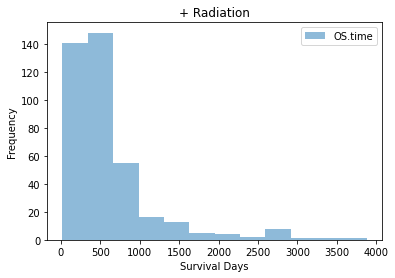

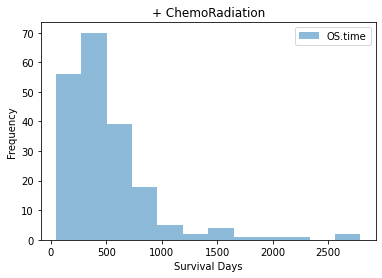

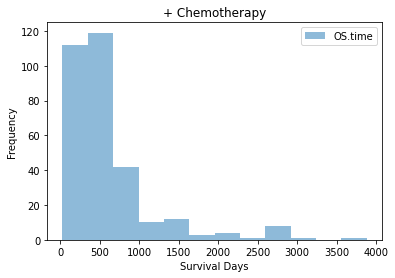

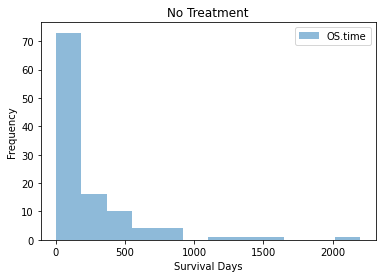

In [22]:
# Distribution of survival data
hist_rt = rt_surv_pres[['OS.time']].copy()
ax = hist_rt.plot.hist(bins=12, alpha=0.5)
ax.set_title('+ Radiation')
ax.set_xlabel('Survival Days')

hist_chemrt = chemrt_surv_pres[['OS.time']].copy()
ax = hist_chemrt.plot.hist(bins=12, alpha=0.5)
ax.set_title('+ ChemoRadiation')
ax.set_xlabel('Survival Days')

hist_chem = chem_surv_pres[['OS.time']].copy()
ax = hist_chem.plot.hist(bins=12, alpha=0.5)
ax.set_title('+ Chemotherapy')
ax.set_xlabel('Survival Days')

hist_notreat = treat_surv_neg[['OS.time']].copy()
ax = hist_notreat.plot.hist(bins=12, alpha=0.5)
ax.set_title('No Treatment')
ax.set_xlabel('Survival Days')

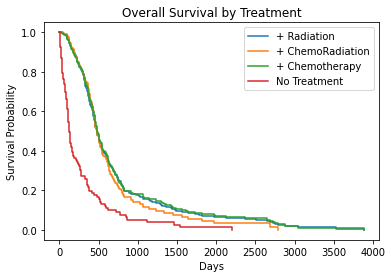

In [23]:
# Kaplan Meier
kmf_rt = KaplanMeierFitter() 
kmf_chemrt = KaplanMeierFitter() 
kmf_chem = KaplanMeierFitter() 
kmf_0treat = KaplanMeierFitter()

durations1 = rt_surv_pres['OS.time'].astype(float).tolist()
event1 = rt_surv_pres['OS'].astype(float).tolist()
durations2 = chemrt_surv_pres['OS.time'].astype(float).tolist()
event2 = chemrt_surv_pres['OS'].astype(float).tolist()
durations3 = chem_surv_pres['OS.time'].astype(float).tolist()
event3 = chem_surv_pres['OS'].astype(float).tolist()
durations4 = treat_surv_neg['OS.time'].astype(float).tolist()
event4 = treat_surv_neg['OS'].astype(float).tolist()

kmf_rt.fit(durations=durations1, event_observed=event1, label='+ Radiation')
kmf_chemrt.fit(durations=durations2, event_observed=event2, label='+ ChemoRadiation')
kmf_chem.fit(durations=durations3, event_observed=event3, label='+ Chemotherapy')
kmf_0treat.fit(durations=durations4, event_observed=event4, label='No Treatment')

kmf_rt.plot(ci_show = False)
kmf_chemrt.plot(ci_show = False)
kmf_chem.plot(ci_show = False)
kmf_0treat.plot(ci_show = False)

plt.title('Overall Survival by Treatment')
plt.ylabel('Survival Probability')
plt.xlabel('Days')
plt.savefig('survival_diff_trts.pdf', transparent=True)
plt.savefig('survival_diff_trts.png')

#### Check distribution of genes

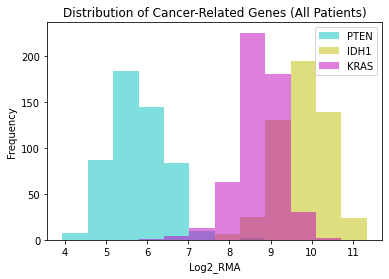

In [24]:
# Histogram of three important genes in full set
histplot = full_df[['PTEN', 'IDH1', 'KRAS']].copy()
ax = histplot.plot.hist(bins=12, alpha=0.5, color=['c', 'y', 'm'])
ax.set_title('Distribution of Cancer-Related Genes (All Patients)')
ax.set_xlabel('Log2_RMA')
plt.savefig('genedist_allpts.pdf', transparent=True)
plt.savefig('genedist_allpts.png', transparent=True)

#### X and y

In [25]:
# Create new filtered y dataframe for OS time
# Regression
y_df = [full_df['OS.time']]
y_df = pd.DataFrame(y_df)
y_df = y_df.transpose()

# create matrix for OS time
y = np.matrix(y_df.to_numpy(dtype=float))

In [26]:
# Create new filtered y dataframe for LHS
# Classification
yc_df = [full_df['LHS']]
yc_df = pd.DataFrame(yc_df)
yc_df = yc_df.transpose()

# create matrix for OS time
yc = np.matrix(yc_df.to_numpy(dtype=float))

In [27]:
# Create new filtered X dataframe
# Drop OS, OS.time, treated
X_df = full_df.drop(['OS.time', 'OS', 'treated', 'LHS', 'OS.months'], axis=1)

# create matrix
X = np.matrix(X_df.to_numpy(dtype=float))
X

matrix([[ 5.409, 10.28 ,  5.639, ...,  1.   ,  0.   ,  0.   ],
        [ 4.972, 11.47 ,  5.276, ...,  1.   ,  0.   ,  0.   ],
        [ 5.335,  4.291,  5.281, ...,  1.   ,  1.   ,  1.   ],
        ...,
        [ 5.02 , 12.16 ,  5.131, ...,  0.   ,  0.   ,  0.   ],
        [ 4.871, 10.84 ,  5.007, ...,  0.   ,  0.   ,  0.   ],
        [ 6.623, 11.7  ,  5.113, ...,  0.   ,  0.   ,  0.   ]])

In [28]:
X[0,-5:]

matrix([[5.7 , 6.36, 1.  , 0.  , 0.  ]])

#### Split for validation (V1 treatments)

##### Regression

In [29]:
# Split training values for validation
from sklearn.model_selection import train_test_split

seed = 17
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

##### Classification

In [30]:
# Split training values for validation
from sklearn.model_selection import train_test_split

seed = 171
test_size = 0.2
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, yc, test_size=test_size, random_state=seed)

#### Feature Selection (V1 treatments)

##### Regression

In [31]:
from sklearn.feature_selection import SelectKBest, f_regression
X_news = SelectKBest(f_regression, k=25).fit(X_train, y_train)
X_train2 = X_news.transform(X_train)

kbest = list(full_df.columns[:-5][X_news._get_support_mask()])
kbest_scores = list(X_news.scores_)
print(kbest)
print(np.shape(X_train2))

['ABBA-1', 'ATP5C1', 'CBR1', 'CHI3L1', 'CHL1', 'DCTD', 'DHRS2', 'DIRAS3', 'DYNLT3', 'EFEMP2', 'GPRASP1', 'HCRTR2', 'IQCG', 'KIAA0495', 'MLNR', 'MSN', 'NSUN5', 'PDPN', 'PRM2', 'RAC3', 'SHANK1', 'SLC25A20', 'SLC4A3', 'TPPP3', 'received_rt']
(414, 25)


##### Classification

In [32]:
from sklearn.feature_selection import SelectKBest, f_classif
Xc_news = SelectKBest(f_classif, k=25).fit(Xc_train, yc_train)
Xc_train2 = Xc_news.transform(Xc_train)

kbestc = list(full_df.columns[:-5][Xc_news._get_support_mask()])
kbestc_scores = list(Xc_news.scores_)
print(kbestc)
print(np.shape(Xc_train2))

['BDH1', 'CCNF', 'CLEC5A', 'EFEMP2', 'EIF3E', 'FAM60A', 'FBXO17', 'G0S2', 'H2AFY2', 'IQCG', 'LDB1', 'MAPK8', 'MOSC2', 'NELL1', 'NSUN5', 'PCBP3', 'PHF16', 'RANBP17', 'SLC25A20', 'SUSD5', 'TMEM22', 'TXNRD2', 'ZNF208', 'received_rt', 'received_chem']
(414, 25)


### V2 with rt treatment used to split the database

This is because our central question is about radiation, and we want to see how the prediction looks in patients that we know receive radiation.

In [33]:
# Remove patients that didn't receive radiation
# Trim rows
rt_full_df = full_df[full_df['received_rt'] != 0]

# drop rt and other treatment columns
rt_full_df = rt_full_df.drop(columns=['received_rt', 'received_chem', 'received_chemrt', 'treated'])
rt_full_df

,A2BP1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAC,AAK1,AAMP,AANAT,...,ZXDA,ZXDB,ZXDC,ZYX,ZZEF1,ZZZ3,OS.time,OS,LHS,OS.months
TCGA-02-0001-01,5.409,10.280,5.639,5.108,5.508,6.501,4.752,4.901,7.236,3.474,...,4.218,4.643,5.537,7.115,5.700,6.360,358.0,1.0,0,11.933333
TCGA-02-0003-01,4.972,11.470,5.276,4.349,5.478,6.539,5.885,4.564,7.311,3.321,...,3.777,4.008,6.327,6.888,5.446,7.456,144.0,1.0,0,4.800000
TCGA-02-0007-01,5.335,4.291,5.281,4.824,6.352,7.187,4.653,4.673,7.424,3.719,...,3.932,3.981,5.428,6.765,5.351,6.918,705.0,1.0,1,23.500000
TCGA-02-0009-01,5.055,10.350,5.124,4.205,5.496,7.675,4.759,4.405,8.052,3.426,...,4.281,4.362,5.307,7.484,5.152,7.114,322.0,1.0,0,10.733333
TCGA-02-0010-01,5.331,8.550,5.351,4.730,5.762,7.996,7.704,4.709,8.435,3.472,...,3.981,4.168,5.458,8.199,5.045,6.421,1077.0,1.0,1,35.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-41-2573-01,9.005,11.570,5.051,4.230,5.708,8.352,4.102,5.409,8.105,3.466,...,4.151,4.009,5.846,8.420,5.546,7.945,272.0,0.0,0,9.066667
TCGA-41-2575-01,5.537,10.900,4.863,4.376,6.033,7.471,4.398,4.821,8.085,3.542,...,4.364,4.058,6.305,7.439,5.585,8.421,290.0,1.0,0,9.666667
TCGA-41-5651-01,8.167,11.580,5.233,4.050,6.054,7.232,4.153,5.110,8.167,3.368,...,4.236,4.185,5.947,8.589,5.648,7.814,460.0,1.0,1,15.333333
TCGA-76-4926-01,5.295,10.650,5.041,4.227,5.928,6.483,4.499,4.327,7.550,3.558,...,4.169,4.380,5.410,9.884,5.572,6.827,138.0,1.0,0,4.600000


#### Survival statistics in the entire database (minus patients missing data)

In [34]:
# Statistics
rt_med_months = rt_full_df['OS.months'].median()
print('Median survival (months):', rt_med_months)

# How many are low/high?
rt_low_high = rt_full_df['LHS'].value_counts()
rt_low_high

# summary for OS.time
rt_os_sum = rt_full_df['OS.time'].describe()
rt_os_sum

# The groups are still pretty well balanced

Median survival (months): 14.7


count     395.000000
mean      595.729114
std       568.007963
min        20.000000
25%       268.000000
50%       441.000000
75%       692.000000
max      3881.000000
Name: OS.time, dtype: float64

#### Plot of survival in the entire database (minus patients missing data)

We don't plot Low/High survival because it doesn't truly represent survival in the tradiational way. It would be confusing to say that after 300 days, Patient X was classified as low survival, or after 1500 days, Patient Y was classified as high survival. This isn't a true "event."

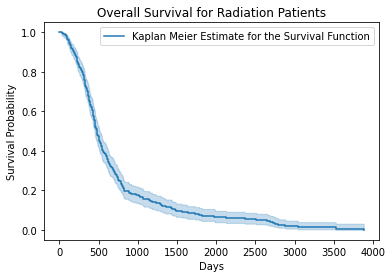

In [35]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 

rt_full_df['OS'] = rt_full_df['OS'].astype(float)
rt_full_df['OS.time'] = rt_full_df['OS.time'].astype(float)

durations = rt_full_df['OS.time'].tolist()
event_observed = rt_full_df['OS'].tolist()

kmf.fit(durations, event_observed,label='Kaplan Meier Estimate for the Survival Function')
kmf.plot()
plt.title('Overall Survival for Radiation Patients')
plt.ylabel('Survival Probability')
plt.xlabel('Days')
plt.savefig('survival_rtpts.pdf', transparent=True)
plt.savefig('survival_rtpts.png')

#### Check distribution of genes

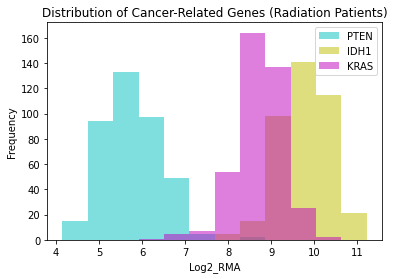

In [36]:
# Histogram of three important genes with -RT patients removed
histplot_rt = rt_full_df[['PTEN', 'IDH1', 'KRAS']].copy()
ax = histplot_rt.plot.hist(bins=12, alpha=0.5, color=['c', 'y', 'm'])
ax.set_xlabel('Log2_RMA')
ax.set_title('Distribution of Cancer-Related Genes (Radiation Patients)')
ax.set_xlabel('Log2_RMA')
plt.savefig('genedist_rtpts.pdf', transparent=True)
plt.savefig('genedist_rtpts.png')

In [37]:
# Create new filtered y dataframe for OS time
# Regression
yr_df = [rt_full_df['OS.time']]
yr_df = pd.DataFrame(yr_df)
yr_df = yr_df.transpose()

# create matrix
yr = np.matrix(yr_df.to_numpy(dtype=float))

In [38]:
# Create new filtered y dataframe for LHS
# Classification
yrc_df = [rt_full_df['LHS']]
yrc_df = pd.DataFrame(yrc_df)
yrc_df = yrc_df.transpose()

# create matrix
yrc = np.matrix(yrc_df.to_numpy(dtype=float))

In [39]:
# Create new filtered X dataframe
# Just drop OS
Xr_df = rt_full_df.drop(['OS.time', 'LHS', 'OS.months'], axis=1)

# create matrix
Xr = np.matrix(Xr_df.to_numpy(dtype=float))
Xr

matrix([[ 5.409, 10.28 ,  5.639, ...,  5.7  ,  6.36 ,  1.   ],
        [ 4.972, 11.47 ,  5.276, ...,  5.446,  7.456,  1.   ],
        [ 5.335,  4.291,  5.281, ...,  5.351,  6.918,  1.   ],
        ...,
        [ 8.167, 11.58 ,  5.233, ...,  5.648,  7.814,  1.   ],
        [ 5.295, 10.65 ,  5.041, ...,  5.572,  6.827,  1.   ],
        [ 5.618, 10.65 ,  5.314, ...,  5.375,  6.951,  1.   ]])

#### Split for validation (V2 treatments)

##### Regression

In [40]:
# Split training values for validation
from sklearn.model_selection import train_test_split

seed = 277
test_size = 0.2
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=test_size, random_state=seed)

##### Classification

In [41]:
# Split training values for validation
from sklearn.model_selection import train_test_split

seed = 2771
test_size = 0.2
Xrc_train, Xrc_test, yrc_train, yrc_test = train_test_split(Xr, yrc, test_size=test_size, random_state=seed) #hiii

#### Feature Selection (V2 treatments)

##### Regression

In [42]:
from sklearn.feature_selection import SelectKBest, f_regression
Xr_news = SelectKBest(f_regression, k=25).fit(Xr_train, yr_train)
Xr_train2 = Xr_news.transform(Xr_train)

kbestr = list(rt_full_df.columns[:-3][Xr_news._get_support_mask()])
kbestr_scores = list(Xr_news.scores_)
print(kbestr)
print(np.shape(Xr_train2))

['AEBP1', 'ARHGAP25', 'ATP2B1', 'ATP5C1', 'C13orf18', 'C1RL', 'CHL1', 'CUTL2', 'DHRS2', 'DIRAS3', 'DYNLT3', 'EFEMP2', 'FLJ11286', 'GFRA1', 'H2AFY2', 'MSN', 'MUC6', 'NSUN5', 'PLEKHQ1', 'RAC3', 'SERPING1', 'SLC24A6', 'SLC2A10', 'STEAP3', 'SWAP70']
(316, 25)


##### Classification

In [43]:
from sklearn.feature_selection import SelectKBest, f_classif
Xrc_news = SelectKBest(f_classif, k=25).fit(Xrc_train, yrc_train)
Xrc_train2 = Xrc_news.transform(Xrc_train)

kbestrc = list(rt_full_df.columns[:-3][Xrc_news._get_support_mask()])
kbestrc_scores = list(Xrc_news.scores_)
print(kbestrc)
print(np.shape(Xrc_train2))

['APOBEC3C', 'C13orf18', 'CLEC5A', 'CNIH3', 'DPM3', 'EFEMP2', 'F3', 'H2AFY2', 'HBEGF', 'HIST1H1E', 'HRASLS3', 'IGFALS', 'MAP2K7', 'MICALL2', 'NHLH2', 'NSUN5', 'PARP3', 'PCYT1A', 'RAB36', 'RNF128', 'RPS10', 'RPS21', 'SWAP70', 'TCAP', 'ZG16']
(316, 25)


#### Chosen features for full_df and rt_full_df based on kbest

In [44]:
model_selected_feats = pd.DataFrame(list(zip(kbest, kbest_scores, kbestc, kbestc_scores, kbestr, 
                                             kbestr_scores, kbestrc, kbestrc_scores)), 
                                    columns =['All Patients + Treatments (regression)', 
                                              'All Patients + Treatments (regression) kscores', 
                                              'All Patients + Treatments (classifier)',
                                              'All Patients + Treatments (classifier) kscores',
                                              'Radiation Patients Only (regression)',
                                              'Radiation Patients Only (regression) kscores',
                                              'Radiation Patients Only (classifier)',
                                              'Radiation Patients Only (classifier) kscores'])
model_selected_feats.to_csv('model_selected_feats.csv')
model_selected_feats

,All Patients + Treatments (regression),All Patients + Treatments (regression) kscores,All Patients + Treatments (classifier),All Patients + Treatments (classifier) kscores,Radiation Patients Only (regression),Radiation Patients Only (regression) kscores,Radiation Patients Only (classifier),Radiation Patients Only (classifier) kscores
0,ABBA-1,3.232091,BDH1,1.010582,AEBP1,0.055992,APOBEC3C,0.268355
1,ATP5C1,4.737901,CCNF,2.096270,ARHGAP25,5.157783,C13orf18,3.478777
2,CBR1,2.257062,CLEC5A,4.366134,ATP2B1,0.023818,CLEC5A,0.463086
3,CHI3L1,4.476245,EFEMP2,0.015213,ATP5C1,5.827559,CNIH3,1.056562
4,CHL1,0.753594,EIF3E,2.410105,C13orf18,0.055631,DPM3,0.083780
5,DCTD,1.459525,FAM60A,0.184714,C1RL,1.497333,EFEMP2,1.090085
6,DHRS2,0.338829,FBXO17,0.932228,CHL1,0.020639,F3,1.588443
7,DIRAS3,0.035422,G0S2,0.409622,CUTL2,1.204316,H2AFY2,0.186204
8,DYNLT3,0.049937,H2AFY2,0.300317,DHRS2,0.036095,HBEGF,0.010008
9,EFEMP2,0.470479,IQCG,1.339836,DIRAS3,0.097804,HIST1H1E,2.213716


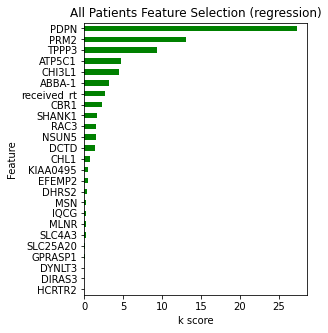

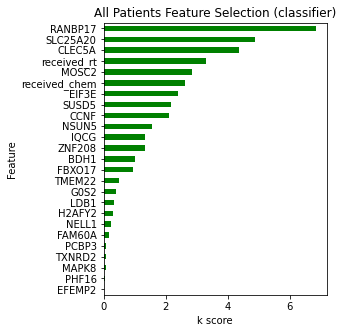

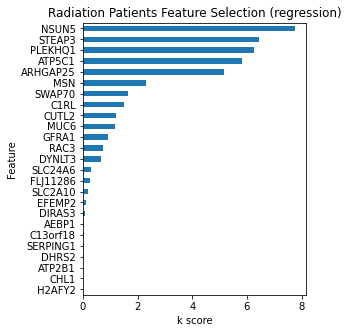

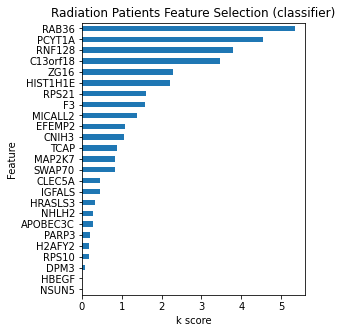

In [45]:
msf1 = model_selected_feats.copy()
msf1 = msf1.sort_values('All Patients + Treatments (regression) kscores')
figsize=(4,5)
ax = msf1.plot.barh(x='All Patients + Treatments (regression)', 
                               y='All Patients + Treatments (regression) kscores', 
                               figsize=figsize, legend=False, color=['g'])
ax.set_title('All Patients Feature Selection (regression)')
plt.xlabel("k score")
plt.ylabel("Feature")
plt.savefig('fig_allpts_regk.png', bbox_inches = "tight")


msf2 = model_selected_feats.copy()
msf2 = msf2.sort_values('All Patients + Treatments (classifier) kscores')
figsize=(4,5)
ax = msf2.plot.barh(x='All Patients + Treatments (classifier)', 
                               y='All Patients + Treatments (classifier) kscores', 
                               figsize=figsize, legend=False, color=['g'])
ax.set_title('All Patients Feature Selection (classifier)')
plt.xlabel("k score")
plt.ylabel("Feature")
plt.savefig('fig_allpts_classk.png', bbox_inches = "tight")


msf3 = model_selected_feats.copy()
msf3 = msf3.sort_values('Radiation Patients Only (regression) kscores')
figsize=(4,5)
ax = msf3.plot.barh(x='Radiation Patients Only (regression)', 
                               y='Radiation Patients Only (regression) kscores', 
                               figsize=figsize, legend=False)
ax.set_title('Radiation Patients Feature Selection (regression)')
plt.xlabel("k score")
plt.ylabel("Feature")
plt.savefig('fig_rtpts_regk.png', bbox_inches = "tight")


msf4 = model_selected_feats.copy()
msf4 = msf4.sort_values('Radiation Patients Only (classifier) kscores')
figsize=(4,5)
ax = msf4.plot.barh(x='Radiation Patients Only (classifier)', 
                               y='Radiation Patients Only (classifier) kscores', 
                               figsize=figsize, legend=False)
ax.set_title('Radiation Patients Feature Selection (classifier)')
plt.xlabel("k score")
plt.ylabel("Feature")
plt.savefig('fig_rtpts_classk.png', bbox_inches = "tight")

#### Highest Scores:

Patients/Regression: PDPN  
PAtients/Class: PANBP17   
Radiation/Regression: NSUN5   
Radiation/Class: RAB36   

## Look at some of the genes used in the models

### Radiation

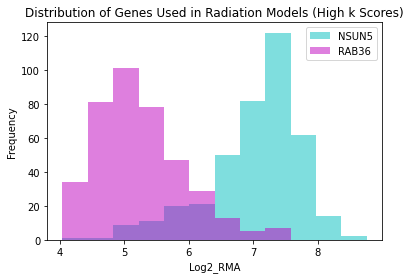

In [46]:
# Histogram of three important genes with -RT patients removed
val_rt = rt_full_df[['NSUN5', 'RAB36']].copy()
ax = val_rt.plot.hist(bins=12, alpha=0.5, color=['c', 'm'])
ax.set_xlabel('Log2_RMA')
ax.set_title('Distribution of Genes Used in Radiation Models (High k Scores)')
ax.set_xlabel('Log2_RMA')
plt.savefig('genes_reg_highk.pdf', transparent=True)

In [47]:
# Statistics for NSUN5
nsun5_med = val_rt['NSUN5'].median()
print(nsun5_med)

# Statistics for RAB36
rab36_med = val_rt['RAB36'].median()
print(rab36_med)

7.204
5.158


In [48]:
# NSUN5 low/high expression, based on median expression level
val_rt['NSUN5_LHE'] = np.where(val_rt['NSUN5']>=nsun5_med, 1, 0)

# RAB36 low/high expression, based on median expression level
val_rt['RAB36_LHE'] = np.where(val_rt['RAB36']>=rab36_med, 1, 0)

In [49]:
# Add OS
expression_os = val_rt.merge(rt_full_df, how='inner', left_index=True, right_index=True)
expression_os = expression_os[['NSUN5_LHE', 'RAB36_LHE', 'OS', 'OS.time']].copy()

# NSUN5 high/low
nsun5_high = expression_os[expression_os['NSUN5_LHE'] == 1]
nsun5_low = expression_os[expression_os['NSUN5_LHE'] == 0]

#RAB36 high/low
rab36_high = expression_os[expression_os['RAB36_LHE'] == 1]
rab36_low = expression_os[expression_os['RAB36_LHE'] == 0]

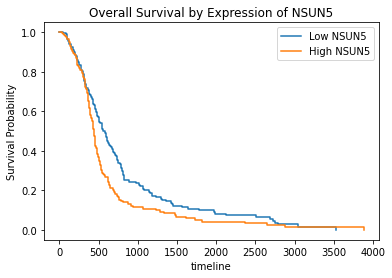

In [50]:
# Kaplan Meier NSUN5
kmf_low = KaplanMeierFitter() 
kmf_high = KaplanMeierFitter() 

durations1 = nsun5_low['OS.time'].astype(float).tolist()
event1 = nsun5_low['OS'].astype(float).tolist()
durations2 = nsun5_high['OS.time'].astype(float).tolist()
event2 = nsun5_high['OS'].astype(float).tolist()

kmf_low.fit(durations=durations1, event_observed=event1, label='Low NSUN5')
kmf_high.fit(durations=durations2, event_observed=event2, label='High NSUN5')

kmf_low.plot(ci_show = False)
kmf_high.plot(ci_show = False)

plt.title('Overall Survival by Expression of NSUN5')
plt.ylabel('Survival Probability')
plt.savefig('survival_nsun5.pdf', transparent=True)

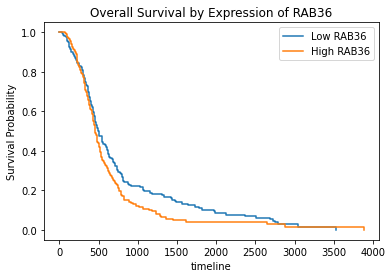

In [51]:
# Kaplan Meier RAB36
kmf_low = KaplanMeierFitter() 
kmf_high = KaplanMeierFitter() 

durations1 = rab36_low['OS.time'].astype(float).tolist()
event1 = rab36_low['OS'].astype(float).tolist()
durations2 = rab36_high['OS.time'].astype(float).tolist()
event2 = rab36_high['OS'].astype(float).tolist()

kmf_low.fit(durations=durations1, event_observed=event1, label='Low RAB36')
kmf_high.fit(durations=durations2, event_observed=event2, label='High RAB36')

kmf_low.plot(ci_show = False)
kmf_high.plot(ci_show = False)

plt.title('Overall Survival by Expression of RAB36')
plt.ylabel('Survival Probability')
plt.savefig('survival_nsun5.pdf', transparent=True)

### All Patients

#### Summary of Survival data for all data splits

Original data: data derived from TCGA    
Treatment dataset for model: Original data + treatment/gene features - patients missing treatment/gene data    
Radiation dataset for model: Original data + gene features - patients without radiation/gene data

In [52]:
# Classification stats
survival = [original_med_months, full_med_months, rt_med_months]
class_stats = pd.DataFrame(list(zip(original_low_high, full_low_high, rt_low_high)), 
                       columns = ['Original', 'All Treatments', 'Radiation Only'], 
                       index=['Low Survival (Classified as 0)', 'High Survival (Classified as 1)'])
class_stats = class_stats.transpose()
class_stats['Median Survival (months)'] = survival
class_stats.to_csv('class_stats.csv')
class_stats

,Low Survival (Classified as 0),High Survival (Classified as 1),Median Survival (months)
Original,361,241,12.333333
All Treatments,306,212,12.583333
Radiation Only,203,192,14.700000


In [53]:
# regression stats
reg_stats = pd.DataFrame(list(zip(original_os_sum, full_os_sum, rt_os_sum)), 
                         index = ['OS Count', 'Mean Survival (days)', 'StDev (Days)', 'Min Survival (days)', 
                                  'OS 25%', 'Median Survival (days)', 'OS 75%', 'Max Survival (days)'],
                         columns = ['Original', 'All Treatments', 'Radiation Only'])
reg_stats = reg_stats.transpose()
reg_stats = reg_stats.drop(columns = ['OS Count', 'OS 25%', 'OS 75%'])
reg_stats.to_csv('reg_stats.csv')
reg_stats

,Mean Survival (days),StDev (Days),Min Survival (days),Median Survival (days),Max Survival (days)
Original,500.642857,536.364905,0.0,370.0,3881.0
All Treatments,512.088803,541.852136,3.0,377.5,3881.0
Radiation Only,595.729114,568.007963,20.0,441.0,3881.0


## Quick Model Test

Variables:  

Regression (all patients): X_train, X_test, y_train, y_test, X_news, X_train2, X, y   
Classification (all patients): Xc_train, Xc_test, yc_train, yc_test, Xc_news, Xc_train2, X, yc   
Regression (rt patients): Xr_train, Xr_test, yr_train, yr_test, Xr_news, Xr_train2, Xr, yr   
Classification (rt patients): Xrc_train, Xrc_test, yrc_train, yrc_test, Xrc_news, Xrc_train2, Xr, yrc   

In [54]:
# Standard imports
# Try maxabsscaler because data should be centered at 0 -- I actually don't think it is
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

### Classification

In [55]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

In [56]:
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["k-Nearest Neighbors", "SVC", "Gaussian Process",
         "Decision Tree", "Random Forest", "Multi-layer Perceptron", "AdaBoost", "GaussianNB",
         "Stochastic Gradient Descent", "Logistic Regression", "Gradient Boost", "LGBM"]

classifiers = [
    make_pipeline(QuantileTransformer(), KNeighborsClassifier()),
    make_pipeline(QuantileTransformer(),SVC(max_iter=100000)),
    make_pipeline(QuantileTransformer(),GaussianProcessClassifier()),
    make_pipeline(QuantileTransformer(),DecisionTreeClassifier(max_depth=5)),
    make_pipeline(QuantileTransformer(),RandomForestClassifier(max_depth=5)),
    make_pipeline(QuantileTransformer(),MLPClassifier(max_iter=100)),
    make_pipeline(QuantileTransformer(),AdaBoostClassifier()),
    make_pipeline(QuantileTransformer(),GaussianNB()),
    make_pipeline(QuantileTransformer(),SGDClassifier(max_iter=100000)),
    make_pipeline(QuantileTransformer(),LogisticRegression(max_iter=100000)),
    make_pipeline(QuantileTransformer(),GradientBoostingClassifier()),
    make_pipeline(QuantileTransformer(),LGBMClassifier())
    ]

#### All Patients

In [57]:
# Xc_train, Xc_test, yc_train, yc_test, Xc_news, Xc_train2, X, yc  

for name, clf in zip(names, classifiers):
    clf.fit(Xc_train2, yc_train)
    y_pred = clf.predict(Xc_news.transform(Xc_test))
    
    # evaluate predictions
    acc = accuracy_score(yc_test, y_pred)
    print('accuracy:', (name, acc))

accuracy: ('k-Nearest Neighbors', 0.6057692307692307)
accuracy: ('SVC', 0.6057692307692307)
accuracy: ('Gaussian Process', 0.625)
accuracy: ('Decision Tree', 0.4807692307692308)
accuracy: ('Random Forest', 0.5576923076923077)
accuracy: ('Multi-layer Perceptron', 0.5288461538461539)
accuracy: ('AdaBoost', 0.5)
accuracy: ('GaussianNB', 0.5865384615384616)
accuracy: ('Stochastic Gradient Descent', 0.5096153846153846)
accuracy: ('Logistic Regression', 0.5576923076923077)
accuracy: ('Gradient Boost', 0.5865384615384616)
accuracy: ('LGBM', 0.5384615384615384)


#### Radiation Only

In [58]:
# Xrc_train, Xrc_test, yrc_train, yrc_test, Xrc_news, Xrc_train2, Xr, yrc

for name, clf in zip(names, classifiers):
    clf.fit(Xrc_train2, yrc_train)
    y_pred = clf.predict(Xrc_news.transform(Xrc_test))
    
    # evaluate predictions
    acc = accuracy_score(yrc_test, y_pred)
    print('MAE:', (name, acc))

MAE: ('k-Nearest Neighbors', 0.5443037974683544)
MAE: ('SVC', 0.4810126582278481)
MAE: ('Gaussian Process', 0.4810126582278481)
MAE: ('Decision Tree', 0.5316455696202531)
MAE: ('Random Forest', 0.45569620253164556)
MAE: ('Multi-layer Perceptron', 0.4936708860759494)
MAE: ('AdaBoost', 0.569620253164557)
MAE: ('GaussianNB', 0.5316455696202531)
MAE: ('Stochastic Gradient Descent', 0.6075949367088608)
MAE: ('Logistic Regression', 0.4936708860759494)
MAE: ('Gradient Boost', 0.5063291139240507)
MAE: ('LGBM', 0.46835443037974683)


Try SVC, AdaBoost, KNN, SGD, Gaussian Process

### Regression

In [59]:
from sklearn.metrics import mean_absolute_error
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from lightgbm import LGBMRegressor

In [60]:
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Support Vector Regression", "Gradient Boosting Regressor", "XGBoost", "Multi-layer Perceptron", 
         "Linear Regression", "SGD", "Kernel Ridge", "Elastic Net", "Bayesian Ridge", "LGBM"]

regressors = [
    make_pipeline(QuantileTransformer(),svm.SVR(max_iter=100000)),
    make_pipeline(QuantileTransformer(),GradientBoostingRegressor()),
    make_pipeline(QuantileTransformer(),XGBRegressor()),
    make_pipeline(QuantileTransformer(),MLPRegressor(max_iter=50)),
    make_pipeline(QuantileTransformer(),LinearRegression()),
    make_pipeline(QuantileTransformer(),SGDRegressor(max_iter=100000)),
    make_pipeline(QuantileTransformer(),KernelRidge()),
    make_pipeline(QuantileTransformer(),ElasticNet(max_iter=100000)),
    make_pipeline(QuantileTransformer(),BayesianRidge()),
    make_pipeline(QuantileTransformer(),LGBMRegressor())
    ]

#### All Patients

In [61]:
# X_train, X_test, y_train, y_test, X_news, X_train2, X, y 

for name, regr in zip(names, regressors):
    regr.fit(X_train2, y_train) #hiii matched using 25 reduced features in and out
    y_pred = regr.predict(X_news.transform(X_test))
    
    # evaluate predictions
    mae = mean_absolute_error(y_test, y_pred)
    print('MAE:', (name, mae))

MAE: ('Support Vector Regression', 332.07644885061467)
MAE: ('Gradient Boosting Regressor', 359.55690149389676)
MAE: ('XGBoost', 365.0645155723278)
MAE: ('Multi-layer Perceptron', 487.7151738089809)
MAE: ('Linear Regression', 328.3080809602359)
MAE: ('SGD', 317.04457446286284)
MAE: ('Kernel Ridge', 330.3531866973987)
MAE: ('Elastic Net', 315.77942425766355)
MAE: ('Bayesian Ridge', 314.3333675241723)
MAE: ('LGBM', 356.127550720316)


#### Radiation Only

In [62]:
# Xr_train, Xr_test, yr_train, yr_test, Xr_news, Xr_train2, Xr, yr   

for name, regr in zip(names, regressors):
    regr.fit(Xr_train2, yr_train)
    y_pred = regr.predict(Xr_news.transform(Xr_test))
    
    # evaluate predictions
    mae = mean_absolute_error(yr_test, y_pred)
    print('MAE:', (name, mae))

MAE: ('Support Vector Regression', 370.82268195910973)
MAE: ('Gradient Boosting Regressor', 394.2055849922776)
MAE: ('XGBoost', 389.9000035539458)
MAE: ('Multi-layer Perceptron', 561.375036972033)
MAE: ('Linear Regression', 380.1644283467281)
MAE: ('SGD', 373.0150429297183)
MAE: ('Kernel Ridge', 378.1026475307443)
MAE: ('Elastic Net', 382.1104168091683)
MAE: ('Bayesian Ridge', 375.9523965673847)
MAE: ('LGBM', 354.00278030136457)


Try SVR, Linear Regression, Gradient Boost, XGB, MLP

# Models

Variables:  

Regression (all patients): X_train, X_test, y_train, y_test, X_news, X_train2, X, y   
Classification (all patients): Xc_train, Xc_test, yc_train, yc_test, Xc_news, Xc_train2, X, yc   
Regression (rt patients): Xr_train, Xr_test, yr_train, yr_test, Xr_news, Xr_train2, Xr, yr   
Classification (rt patients): Xrc_train, Xrc_test, yrc_train, yrc_test, Xrc_news, Xrc_train2, Xr, yrc  

Choose 5 models each for classification/regression based on initial performance

# Regression Models (All Patients/Treatments)

### Model 1: Support Vector Regression (SVR) Model - All patients with treatment data trained

Include all features from full_df. Here, we want to include treatments as features.  
X_train, X_test, y_train, y_test, X_news, X_train2, X, y  

In [63]:
from sklearn import svm

param_grid = {
                 'svr__kernel': ('rbf', 'sigmoid', 'linear', 'poly'),
                 'svr__gamma': [0.001, 0.01, 0.1],
                 'svr__C': [0.1, 1, 10, 100],
                 'svr__tol': [.0001, .001, .01],
             }

In [64]:
clf = make_pipeline(QuantileTransformer(), svm.SVR(max_iter=50000))
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(X_train2, y_train)
grid_model.best_params_

{'svr__C': 100, 'svr__gamma': 0.1, 'svr__kernel': 'rbf', 'svr__tol': 0.01}

### Model 2: Gradient Boosting Regressor

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

# print(reg.get_params())
param_grid = {
                 'gradientboostingregressor__loss': ('squared_error', 'absolute_error', 'huber', 'quantile'),
                 'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1],
                 'gradientboostingregressor__n_estimators': [1, 10, 100, 1000],
             }

In [66]:
reg = make_pipeline(QuantileTransformer(), GradientBoostingRegressor())
grid_model = GridSearchCV(reg, param_grid=param_grid, refit=True)
grid_model.fit(X_train2, y_train)
grid_model.best_params_

{'gradientboostingregressor__learning_rate': 0.01,
 'gradientboostingregressor__loss': 'huber',
 'gradientboostingregressor__n_estimators': 1000}

### Model 3: XGB Regression

In [67]:
from xgboost.sklearn import XGBRegressor

param_grid = {  
            "xgbregressor__n_estimators": [50, 100, 250],
            "xgbregressor__max_depth": [1, 3, 10, 25],
            "xgbregressor__learning_rate": [0.001, 0.01, 0.1]
        }

In [68]:
xgb = make_pipeline(QuantileTransformer(), XGBRegressor())
grid_model = GridSearchCV(xgb, param_grid=param_grid, refit=True)
grid_model.fit(X_train2, y_train)
grid_model.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 1,
 'xgbregressor__n_estimators': 100}

### Model 4: MLP Regressor

Only radiation parents from rt_full_df

In [69]:
from sklearn.neural_network import MLPRegressor

param_grid = {
                 'mlpregressor__hidden_layer_sizes': [(100,), (100,100)],
                 'mlpregressor__activation': [('relu')], # 'identity', 'logistic', 'tanh', 
                 'mlpregressor__solver': [('adam')],# 'sgd', 'adam'), lbfgs, 
                 'mlpregressor__alpha': [0.00001, 0.0001, 0.001],
                 'mlpregressor__learning_rate': ('constant', 'invscaling',  'adaptive'), # 'constant', 
                 'mlpregressor__tol': [0.0001, 0.001, 0.01]
             }

In [70]:
regr = make_pipeline(QuantileTransformer(), MLPRegressor(max_iter=50))
grid_model = GridSearchCV(regr, param_grid=param_grid, refit=True)
grid_model.fit(X_train2, y_train)
grid_model.best_params_

{'mlpregressor__activation': 'relu',
 'mlpregressor__alpha': 1e-05,
 'mlpregressor__hidden_layer_sizes': (100, 100),
 'mlpregressor__learning_rate': 'invscaling',
 'mlpregressor__solver': 'adam',
 'mlpregressor__tol': 0.01}

### Model 5: Linear Regression

Only radiation parents from rt_full_df

In [71]:
from sklearn.linear_model import LinearRegression

param_grid = {
                 'linearregression__n_jobs': [1, 2, 5, 10, 100],
             }

In [72]:
regr = make_pipeline(QuantileTransformer(), LinearRegression())
grid_model = GridSearchCV(regr, param_grid=param_grid, refit=True)
grid_model.fit(X_train2, y_train)
grid_model.best_params_

{'linearregression__n_jobs': 1}

# Classification Models (All Patients/Treatments)

Try the classifier to narrow things down -- survival time vs. low/high survival   
Xc_train, Xc_test, yc_train, yc_test, Xc_news, Xc_train2, X, yc   

### Model 1: Gaussian Process

Include all features from full_df. Here, we want to include treatments as features.

In [73]:
from sklearn.gaussian_process import GaussianProcessClassifier

param_grid = {
                 'gaussianprocessclassifier__multi_class': ('one_vs_rest', 'one_vs_one'),
                 'gaussianprocessclassifier__max_iter_predict': [10, 25, 100, 500],
             }

In [74]:
clf = make_pipeline(QuantileTransformer(), GaussianProcessClassifier())
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xc_train2, yc_train)
grid_model.best_params_

{'gaussianprocessclassifier__max_iter_predict': 10,
 'gaussianprocessclassifier__multi_class': 'one_vs_rest'}

### Model 2: SGD Classifier

In [75]:
from sklearn.linear_model import SGDClassifier

param_grid = {
                 'sgdclassifier__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
                 'sgdclassifier__penalty': ('l2', 'l1', 'elasticnet'),
                 'sgdclassifier__alpha': [0.00001, 0.0001, 0.001],
#                  'sgdclassifier__learning_rate': ('constant', 'optimal', 'invscaling', 'adaptive'),
             }

In [76]:
clf = make_pipeline(QuantileTransformer(), SGDClassifier(max_iter=50000))
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xc_train2, yc_train)
grid_model.best_params_

{'sgdclassifier__alpha': 0.001,
 'sgdclassifier__loss': 'log',
 'sgdclassifier__penalty': 'l1'}

### Model 3: MLP Classifier

In [77]:
from sklearn.neural_network import MLPClassifier

param_grid = {
                 'mlpclassifier__hidden_layer_sizes': [(100,), (100,100)],
                 'mlpclassifier__activation': ('identity', 'logistic', 'tanh', 'relu'),
                 'mlpclassifier__solver': [('lbfgs')],# 'sgd', 'adam'),
                 'mlpclassifier__alpha': [0.00001, 0.0001, 0.001],
                 'mlpclassifier__learning_rate': ('invscaling',  'adaptive'), # 'constant', 
                 'mlpclassifier__tol': [0.0001, 0.001, 0.01]
             }

In [78]:
clf = make_pipeline(QuantileTransformer(), MLPClassifier(max_iter=50))
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xc_train2, yc_train)
grid_model.best_params_

{'mlpclassifier__activation': 'logistic',
 'mlpclassifier__alpha': 1e-05,
 'mlpclassifier__hidden_layer_sizes': (100,),
 'mlpclassifier__learning_rate': 'adaptive',
 'mlpclassifier__solver': 'lbfgs',
 'mlpclassifier__tol': 0.0001}

### Model 4: KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
                 'kneighborsclassifier__n_neighbors': [2, 3, 5, 7, 10, 15],
                 'kneighborsclassifier__weights': ('uniform', 'distance'),
                 'kneighborsclassifier__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
             }

In [80]:
neigh = make_pipeline(QuantileTransformer(), KNeighborsClassifier())
grid_model = GridSearchCV(neigh, param_grid=param_grid, refit=True)
grid_model.fit(Xc_train2, yc_train)
grid_model.best_params_

{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 10,
 'kneighborsclassifier__weights': 'uniform'}

### Model 5: AdaBoost

In [81]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
                 'adaboostclassifier__n_estimators': [5, 10, 25, 50, 100],
                 'adaboostclassifier__learning_rate': [0.1, 0.5, 1.0, 5.0, 10.0],
                 'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R'),
             }

In [82]:
clf = make_pipeline(QuantileTransformer(), AdaBoostClassifier())
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xc_train2, yc_train)
grid_model.best_params_

{'adaboostclassifier__algorithm': 'SAMME.R',
 'adaboostclassifier__learning_rate': 0.5,
 'adaboostclassifier__n_estimators': 50}

# Regression Models (Radiation Patients Only)

Xr_train, Xr_test, yr_train, yr_test, Xr_news, Xr_train2, Xr, yr   

### Model 1: Support Vector Regression (SVR) Model

Only radiation patients from rt_full_df. Treatments are not included as features. 

In [83]:
from sklearn import svm

param_grid = {
                 'svr__kernel': ('rbf', 'sigmoid', 'linear', 'poly'),
                 'svr__gamma': [0.001, 0.01, 0.1],
                 'svr__C': [0.1, 1, 10, 100],
                 'svr__tol': [.0001, .001, .01],
             }

In [84]:
clf = make_pipeline(QuantileTransformer(), svm.SVR(max_iter=50000))
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xr_train2, yr_train)
grid_model.best_params_

{'svr__C': 100, 'svr__gamma': 0.001, 'svr__kernel': 'linear', 'svr__tol': 0.01}

### Model 2: Gradient Boosting Regressor

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

# print(reg.get_params())
param_grid = {
                 'gradientboostingregressor__loss': ('squared_error', 'absolute_error', 'huber', 'quantile'),
                 'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1],
                 'gradientboostingregressor__n_estimators': [1, 10, 100, 1000],
             }

In [86]:
reg = make_pipeline(QuantileTransformer(), GradientBoostingRegressor())
grid_model = GridSearchCV(reg, param_grid=param_grid, refit=True)
grid_model.fit(Xr_train2, yr_train)
grid_model.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__loss': 'huber',
 'gradientboostingregressor__n_estimators': 100}

### Model 3: XGB Regression

In [87]:
from xgboost.sklearn import XGBRegressor

param_grid = {  
            "xgbregressor__n_estimators": [50, 100, 250],
            "xgbregressor__max_depth": [1, 3, 10, 25],
            "xgbregressor__learning_rate": [0.001, 0.01, 0.1]
        }

In [88]:
xgb = make_pipeline(QuantileTransformer(), XGBRegressor())
grid_model = GridSearchCV(xgb, param_grid=param_grid, refit=True)
grid_model.fit(Xr_train2, yr_train)
grid_model.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 1,
 'xgbregressor__n_estimators': 50}

### Model 4: MLP Regressor

Only radiation parents from rt_full_df

In [89]:
from sklearn.neural_network import MLPRegressor

param_grid = {
                 'mlpregressor__hidden_layer_sizes': [(100,), (100,100)],
                 'mlpregressor__activation': [('relu')], # 'identity', 'logistic', 'tanh', 
                 'mlpregressor__solver': [('adam')],# 'sgd', 'adam'), lbfgs, 
                 'mlpregressor__alpha': [0.00001, 0.0001, 0.001],
                 'mlpregressor__learning_rate': ('constant', 'invscaling',  'adaptive'), # 'constant', 
                 'mlpregressor__tol': [0.0001, 0.001, 0.01]
             }

In [90]:
regr = make_pipeline(QuantileTransformer(), MLPRegressor(max_iter=50))
grid_model = GridSearchCV(regr, param_grid=param_grid, refit=True)
grid_model.fit(Xr_train2, yr_train)
grid_model.best_params_

{'mlpregressor__activation': 'relu',
 'mlpregressor__alpha': 0.001,
 'mlpregressor__hidden_layer_sizes': (100, 100),
 'mlpregressor__learning_rate': 'adaptive',
 'mlpregressor__solver': 'adam',
 'mlpregressor__tol': 0.0001}

### Model 5: Linear Regression

Only radiation parents from rt_full_df

In [91]:
from sklearn.linear_model import LinearRegression

param_grid = {
                 'linearregression__n_jobs': [1, 2, 5, 10, 100],
             }

In [92]:
regr = make_pipeline(QuantileTransformer(), LinearRegression())
grid_model = GridSearchCV(regr, param_grid=param_grid, refit=True)
grid_model.fit(Xr_train2, yr_train)
grid_model.best_params_

{'linearregression__n_jobs': 1}

# Classification Models using High/Low Survival Groups (Radiation Patients Only)

Xrc_train, Xrc_test, yrc_train, yrc_test, Xrc_news, Xrc_train2, Xr, yrc 

### Model 1: Gaussian Process

Include all features from full_df. Here, we want to include treatments as features.

In [93]:
from sklearn.gaussian_process import GaussianProcessClassifier

param_grid = {
                 'gaussianprocessclassifier__multi_class': ('one_vs_rest', 'one_vs_one'),
                 'gaussianprocessclassifier__max_iter_predict': [10, 25, 100, 500],
             }

In [94]:
clf = make_pipeline(QuantileTransformer(), GaussianProcessClassifier())
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xrc_train2, yrc_train)
grid_model.best_params_

{'gaussianprocessclassifier__max_iter_predict': 10,
 'gaussianprocessclassifier__multi_class': 'one_vs_rest'}

### Model 2: SGD Classifier

In [95]:
from sklearn.linear_model import SGDClassifier

param_grid = {
                 'sgdclassifier__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
                 'sgdclassifier__penalty': ('l2', 'l1', 'elasticnet'),
                 'sgdclassifier__alpha': [0.00001, 0.0001, 0.001],
#                  'sgdclassifier__learning_rate': ('constant', 'optimal', 'invscaling', 'adaptive'),
             }

In [96]:
clf = make_pipeline(QuantileTransformer(), SGDClassifier(max_iter=50000))
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xrc_train2, yrc_train)
grid_model.best_params_

{'sgdclassifier__alpha': 1e-05,
 'sgdclassifier__loss': 'squared_hinge',
 'sgdclassifier__penalty': 'l1'}

### Model 3: MLP Classifier

In [97]:
from sklearn.neural_network import MLPClassifier

param_grid = {
                 'mlpclassifier__hidden_layer_sizes': [(100,), (100,100)],
                 'mlpclassifier__activation': ('identity', 'logistic', 'tanh', 'relu'),
                 'mlpclassifier__solver': [('lbfgs')],# 'sgd', 'adam'),
                 'mlpclassifier__alpha': [0.00001, 0.0001, 0.001],
                 'mlpclassifier__learning_rate': ('invscaling',  'adaptive'), # 'constant', 
                 'mlpclassifier__tol': [0.0001, 0.001, 0.01]
             }

In [98]:
clf = make_pipeline(QuantileTransformer(), MLPClassifier(max_iter=50))
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xrc_train2, yrc_train)
grid_model.best_params_

{'mlpclassifier__activation': 'identity',
 'mlpclassifier__alpha': 1e-05,
 'mlpclassifier__hidden_layer_sizes': (100,),
 'mlpclassifier__learning_rate': 'adaptive',
 'mlpclassifier__solver': 'lbfgs',
 'mlpclassifier__tol': 0.0001}

### Model 4: KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
                 'kneighborsclassifier__n_neighbors': [2, 3, 5, 7, 10, 15],
                 'kneighborsclassifier__weights': ('uniform', 'distance'),
                 'kneighborsclassifier__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
             }

In [100]:
neigh = make_pipeline(QuantileTransformer(), KNeighborsClassifier())
grid_model = GridSearchCV(neigh, param_grid=param_grid, refit=True)
grid_model.fit(Xrc_train2, yrc_train)
grid_model.best_params_

{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 10,
 'kneighborsclassifier__weights': 'uniform'}

### Model 5: AdaBoost

In [101]:
from sklearn.ensemble import AdaBoostClassifier

# First exploration of parameters
param_grid = {
                 'adaboostclassifier__n_estimators': [5, 10, 25, 50, 100],
                 'adaboostclassifier__learning_rate': [0.1, 0.5, 1.0, 5.0, 10.0],
                 'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R'),
             }

In [102]:
clf = make_pipeline(QuantileTransformer(), AdaBoostClassifier())
grid_model = GridSearchCV(clf, param_grid=param_grid, refit=True)
grid_model.fit(Xrc_train2, yrc_train)
grid_model.best_params_

{'adaboostclassifier__algorithm': 'SAMME',
 'adaboostclassifier__learning_rate': 0.5,
 'adaboostclassifier__n_estimators': 100}

## Final Model Test with updated params

Variables:  

Regression (all patients): X_train, X_test, y_train, y_test, X_news, X_train2, X, y   
Classification (all patients): Xc_train, Xc_test, yc_train, yc_test, Xc_news, Xc_train2, X, yc   
Regression (rt patients): Xr_train, Xr_test, yr_train, yr_test, Xr_news, Xr_train2, Xr, yr   
Classification (rt patients): Xrc_train, Xrc_test, yrc_train, yrc_test, Xrc_news, Xrc_train2, Xr, yrc   

### Classification

#### All Patients

In [103]:
# All patients -- tuned
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Gaussian Process", "Stochastic Gradient Descent", "Multi-layer Perceptron", "k-Nearest Neighbors", "AdaBoost"]

classifiers = [
    make_pipeline(QuantileTransformer(), GaussianProcessClassifier(multi_class='one_vs_rest', max_iter_predict=10)),
    make_pipeline(QuantileTransformer(), SGDClassifier(loss='log', penalty='elasticnet', alpha=0.001, max_iter=100000)),
    make_pipeline(QuantileTransformer(), MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', learning_rate='invscaling', 
                                                       solver='lbfgs', alpha=0.00001, tol=0.01, max_iter=100)),
    make_pipeline(QuantileTransformer(), KNeighborsClassifier(algorithm='auto', weights='uniform', n_neighbors=10)),
    make_pipeline(QuantileTransformer(), AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.5, n_estimators=50)),
    ]

MAE: ('Gaussian Process', 0.625)
MAE: ('Stochastic Gradient Descent', 0.5480769230769231)
MAE: ('Multi-layer Perceptron', 0.5576923076923077)
MAE: ('k-Nearest Neighbors', 0.6346153846153846)
MAE: ('AdaBoost', 0.5288461538461539)


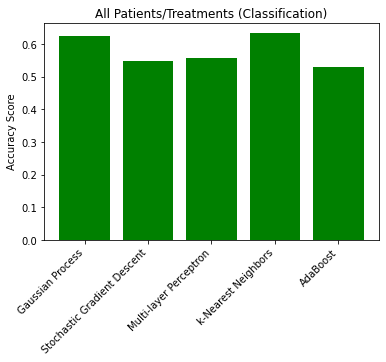

In [104]:
# Xc_train, Xc_test, yc_train, yc_test, Xc_news, Xc_train2, X, yc  

accs = []

for name, clf in zip(names, classifiers):
    clf.fit(Xc_train2, yc_train)
    y_pred = clf.predict(Xc_news.transform(Xc_test))
    
    # evaluate predictions
    acc = accuracy_score(yc_test, y_pred)
    accs.append(acc)
    print('MAE:', (name, acc))

fig,ax = plt.subplots()
ax.bar(names, accs, color=['g'])
ax.set_title('All Patients/Treatments (Classification)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy Score')
fig.savefig('allpts_class.pdf', transparent=True, bbox_inches = "tight")
fig.savefig('allpts_class.png', bbox_inches = "tight")

#### Radiation Only

In [105]:
# radiation patients -- tuned
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Gaussian Process", "Stochastic Gradient Descent", "Multi-layer Perceptron", "k-Nearest Neighbors", "AdaBoost"]

classifiers = [
    make_pipeline(QuantileTransformer(), GaussianProcessClassifier(multi_class='one_vs_rest', max_iter_predict=10)),
    make_pipeline(QuantileTransformer(), SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=100000)),
    make_pipeline(QuantileTransformer(), MLPClassifier(hidden_layer_sizes=(100,), activation='identity', learning_rate='adaptive', 
                                                  solver='lbfgs', alpha=0.0001, tol=0.0001, max_iter=100)),
    make_pipeline(QuantileTransformer(), KNeighborsClassifier(algorithm='auto', weights='uniform', n_neighbors=10)),
    make_pipeline(QuantileTransformer(), AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5, n_estimators=100))
    ]

MAE: ('Gaussian Process', 0.4810126582278481)
MAE: ('Stochastic Gradient Descent', 0.43037974683544306)
MAE: ('Multi-layer Perceptron', 0.4936708860759494)
MAE: ('k-Nearest Neighbors', 0.5316455696202531)
MAE: ('AdaBoost', 0.5316455696202531)


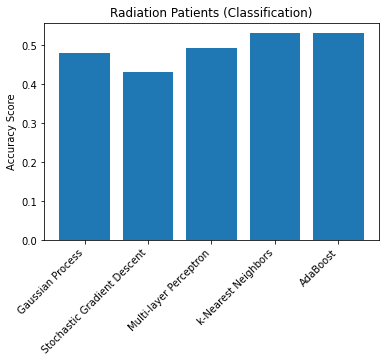

In [106]:
# Xrc_train, Xrc_test, yrc_train, yrc_test, Xrc_news, Xrc_train2, Xr, yrc

accs = []

for name, clf in zip(names, classifiers):
    clf.fit(Xrc_train2, yrc_train)
    y_pred = clf.predict(Xrc_news.transform(Xrc_test))
    
    # evaluate predictions
    acc = accuracy_score(yrc_test, y_pred)
    accs.append(acc)
    print('MAE:', (name, acc))
    
fig,ax = plt.subplots()
ax.bar(names,accs)
ax.set_title('Radiation Patients (Classification)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy Score')
fig.savefig('rtpts_class.pdf', transparent=True, bbox_inches = "tight")
fig.savefig('rtpts_class.png', bbox_inches = "tight")

### Regression

#### All Patients

In [107]:
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Support Vector Regression", "Gradient Boosting Regressor", "XGBoost",  "Multi-layer Perceptron", "Linear Regression"]

regressors = [
    make_pipeline(QuantileTransformer(), svm.SVR(kernel='rbf', C=100, tol=0.01, gamma = 0.1, max_iter=100000)),
    make_pipeline(QuantileTransformer(), GradientBoostingRegressor(loss='huber', learning_rate=0.01, n_estimators=1000)),
    make_pipeline(QuantileTransformer(), XGBRegressor(n_estimators=100, max_depth=1, learning_rate=0.1)),
    make_pipeline(QuantileTransformer(), MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', learning_rate='invscaling', 
                                                  solver='adam', alpha=0.00001, tol=0.01, max_iter=100)),
    make_pipeline(QuantileTransformer(), LinearRegression(n_jobs=1))
    ]

MAE: ('Support Vector Regression', 297.96063410798087)
MAE: ('Gradient Boosting Regressor', 337.0200673735622)
MAE: ('XGBoost', 337.0278220543495)
MAE: ('Multi-layer Perceptron', 321.23727250308065)
MAE: ('Linear Regression', 328.3080809602359)


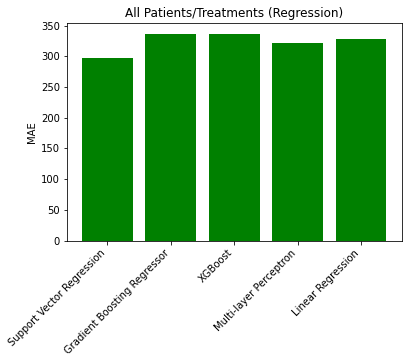

In [108]:
# All patients -- tuned
# X_train, X_test, y_train, y_test, X_news, X_train2, X, y 

maes = []

for name, regr in zip(names, regressors):
    regr.fit(X_train2, y_train)   #hiii fixed input and output dimension to 25
    y_pred = regr.predict(X_news.transform(X_test))
    
    # evaluate predictions
    mae = mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    print('MAE:', (name, mae))
    
fig,ax = plt.subplots()
ax.bar(names,maes, color=['g'])
ax.set_title('All Patients/Treatments (Regression)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE')
fig.savefig('allpts_reg.pdf', transparent=True, bbox_inches = "tight")
fig.savefig('allpts_reg.png', bbox_inches = "tight")

#### Radiation Only

In [109]:
# Radiation -- tuned
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Support Vector Regression", "Gradient Boosting Regressor", "XGBoost",  "Multi-layer Perceptron", "Linear Regression"]

regressors = [
    make_pipeline(QuantileTransformer(), svm.SVR(kernel='linear', C=100, tol=0.01, gamma = 0.001, max_iter=100000)),
    make_pipeline(QuantileTransformer(), GradientBoostingRegressor(loss='huber', learning_rate=0.01, n_estimators=1000)),
    make_pipeline(QuantileTransformer(), XGBRegressor(n_estimators=50, max_depth=1, learning_rate=0.1)),
    make_pipeline(QuantileTransformer(), MLPRegressor(hidden_layer_sizes=(100,100), activation='relu', learning_rate='constant', 
                                                  solver='adam', alpha=0.001, tol=0.001, max_iter=100)),
    make_pipeline(QuantileTransformer(), LinearRegression(n_jobs=1))
    ]

MAE: ('Support Vector Regression', 470.7063661417211)
MAE: ('Gradient Boosting Regressor', 574.0557853629814)
MAE: ('XGBoost', 577.7544914921627)
MAE: ('Multi-layer Perceptron', 552.4415683536431)
MAE: ('Linear Regression', 591.0370869722302)


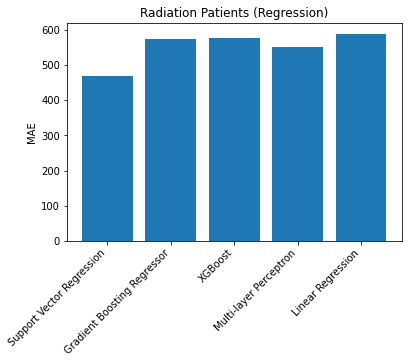

In [110]:
# Xr_train, Xr_test, yr_train, yr_test, Xr_news, Xr_train2, Xr, yr   

maes = []

for name, regr in zip(names, regressors):
    regr.fit(Xr_train2, yr_train)
    y_pred = regr.predict(Xr_news.transform(Xr_test))
    
    # evaluate predictions
    mae = mean_absolute_error(yrc_test, y_pred)
    maes.append(mae)
    print('MAE:', (name, mae))

fig,ax = plt.subplots()
ax.bar(names,maes)
ax.set_title('Radiation Patients (Regression)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE')
fig.savefig('rtpts_reg.pdf', transparent=True, bbox_inches = "tight")
fig.savefig('rtpts_reg.png', bbox_inches = "tight")

## Models used

In [111]:
names1 = ["k-Nearest Neighbors", "SVC", "Gaussian Process",
         "Decision Tree", "Random Forest", "Multi-layer Perceptron", "AdaBoost", "GaussianNB",
         "Stochastic Gradient Descent", "Logistic Regression", "Gradient Boost", "LGBM"]
names2 = ["Gaussian Process", "Stochastic Gradient Descent", "Multi-layer Perceptron", "k-Nearest Neighbors", "AdaBoost"]
names3 = ["Support Vector Regression", "Gradient Boosting Regressor", "XGBoost", "Multi-layer Perceptron", 
         "Linear Regression", "SGD", "Kernel Ridge", "Elastic Net", "Bayesian Ridge", "LGBM"]

names4 = ["Support Vector Regression", "Gradient Boosting Regressor", "XGBoost",  "Multi-layer Perceptron", "Linear Regression"]